In [1]:
import theseus as th
from planner import MotionPlannerObjective
import torch
import numpy as np
import matplotlib.pyplot as plt

dtype = torch.double
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [202]:
CELL_SIZE = 0.05
HORIZON = 30
TOTAL_TIME = 60.0 # this dictates the discretization time step (dt = TOTAL_TIME / HORIZON)
CURRENT_STATE = torch.tensor((45*CELL_SIZE, 40*CELL_SIZE, 0))  # x, y, theta
GOAL_POSITION = torch.tensor((45*CELL_SIZE, 20*CELL_SIZE))  # x, y
SDF_ORIGIN = (0, 0)

In [219]:
objective = MotionPlannerObjective(
    total_time=TOTAL_TIME,
    horizon=HORIZON,
    current_velocity=torch.tensor([0.0, 0.0], dtype=dtype),
    x_velocity_bounds=torch.tensor([-5, 5], dtype=dtype),
    y_velocity_bounds=torch.tensor([-5, 5], dtype=dtype),
    x_acceleration_bounds=torch.tensor([-1, 1], dtype=dtype),
    y_acceleration_bounds=torch.tensor([-1, 1], dtype=dtype),
    robot_radius=1,  # REPLACE WITH ACTUAL RADIUS
    safety_distance=1,  # REPLACE WITH ACTUAL SAFETY DISTANCE
    local_map_size=60,  # REPLACE WITH ACTUAL MAP SIZE
    goal_cost = 50,
    acceleration_cost = 10,
    control_cost = 100,
    velocity_cost = 100,
    current_state_cost = 2000,
    dynamic_cost = 2000,
    collision_cost = 500
)

optimizer = th.LevenbergMarquardt(
    objective,
    th.CholeskyDenseSolver,
    max_iterations=50,
    step_size=1,
)
motion_planner = th.TheseusLayer(optimizer)
motion_planner.to(device, dtype=torch.double)


In [220]:
def get_straight_line_inputs(start: torch.Tensor, goal: torch.Tensor, total_time, horizon):
    # Returns a dictionary with state and acceleration variable names associated to a
    # straight line trajectory between start and goal in SE(2) space

    # Calculate start and goal positions
    start_pos = start[..., :2]  # Extracting the 2D position from SE(2)
    goal_pos = goal  # Assuming goal is already a 2D point

    # Calculate distances and average accelerations for each batch element
    start_goal_dist = goal_pos - start_pos  # Shape: (batch_size, 2)
    avg_acc = 2 * start_goal_dist / (total_time**2)  # Shape: (batch_size, 2)
    unit_horizon = start_goal_dist / (horizon - 1)  # Shape: (batch_size, 2)

    # Create input dictionary
    input_dict = {}

    for i in range(horizon + 1):
        state_i = start_pos + unit_horizon * i  # Shape: (batch_size, 2)
        # Concatenate the 2D position with the orientation
        input_dict[f"state_{i}"] = torch.concat(
            [state_i, start[..., 2:]], dim=-1)

        if i == horizon:
            continue

        if i == 0 or i == horizon - 1:
            # Zero acceleration at start and end
            acceleration_i = torch.zeros_like(avg_acc)
        else:
            acceleration_i = avg_acc

        input_dict[f"acceleration_{i}"] = acceleration_i

    return input_dict


torch.Size([60, 60])


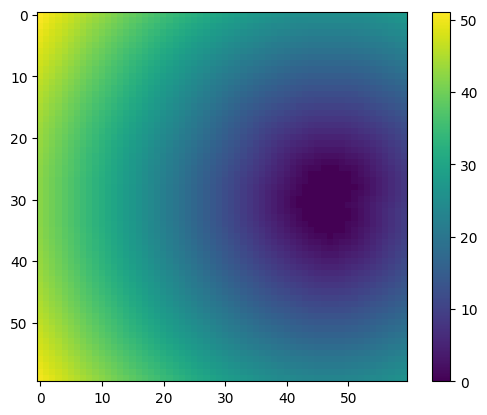

In [221]:

file_path = "sdf_array_2.npy"
sdf = torch.tensor(np.load(file_path), dtype=dtype)
plt.imshow(sdf)
plt.colorbar()
print(sdf.shape)

In [222]:
planner_inputs = {
    # REPLACE WITH SDF DATA
    'sdf_data': sdf.unsqueeze(0).to(device),
    'sdf_origin': torch.tensor([SDF_ORIGIN[0], SDF_ORIGIN[1]], dtype=dtype).unsqueeze(0).to(device),
    'cell_size': torch.tensor([CELL_SIZE], dtype=dtype).unsqueeze(0).to(device),
    'current_state': torch.tensor([CURRENT_STATE[0], CURRENT_STATE[1], torch.cos(CURRENT_STATE[2]), torch.sin(CURRENT_STATE[2])], dtype=dtype).unsqueeze(0).to(device),
    'goal_position': torch.tensor([GOAL_POSITION[0], GOAL_POSITION[1]], dtype=dtype).unsqueeze(0).to(device),
}
planner_inputs.update(get_straight_line_inputs(
    planner_inputs['current_state'], planner_inputs['goal_position'], TOTAL_TIME, HORIZON))


In [223]:
with torch.no_grad():
    final_values, info = motion_planner.forward(
        planner_inputs,
        optimizer_kwargs={
            "track_best_solution": True,
            "verbose": True,
            "damping": 0.1,
        }
    )

solution_dictionary = info.best_solution


Nonlinear optimizer. Iteration: 0. Error: 7630094.296510423
Nonlinear optimizer. Iteration: 1. Error: 4664355.975147413
Nonlinear optimizer. Iteration: 2. Error: 2795591.177681047
Nonlinear optimizer. Iteration: 3. Error: 2340182.7005390814
Nonlinear optimizer. Iteration: 4. Error: 910823.6663853737
Nonlinear optimizer. Iteration: 5. Error: 28338.52279093374
Nonlinear optimizer. Iteration: 6. Error: 51557.99245966582
Nonlinear optimizer. Iteration: 7. Error: 11336.608264279199
Nonlinear optimizer. Iteration: 8. Error: 169075.4420336554
Nonlinear optimizer. Iteration: 9. Error: 14327.007480065568
Nonlinear optimizer. Iteration: 10. Error: 1647206.4729847808
Nonlinear optimizer. Iteration: 11. Error: 491221.74581636686
Nonlinear optimizer. Iteration: 12. Error: 184575.25585580693
Nonlinear optimizer. Iteration: 13. Error: 5441.194839434254
Nonlinear optimizer. Iteration: 14. Error: 109692.11281319402
Nonlinear optimizer. Iteration: 15. Error: 5591.002260792369
Nonlinear optimizer. Iterat

In [224]:
print(solution_dictionary)


{'state_1': tensor([[2.1598, 1.8637, 1.0000, 0.0000]], dtype=torch.float64), 'state_2': tensor([[2.0810, 1.7325, 1.0000, 0.0000]], dtype=torch.float64), 'state_3': tensor([[2.0218, 1.6064, 1.0000, 0.0000]], dtype=torch.float64), 'state_4': tensor([[1.9883, 1.4867, 1.0000, 0.0000]], dtype=torch.float64), 'state_5': tensor([[1.9754, 1.3791, 1.0000, 0.0000]], dtype=torch.float64), 'state_6': tensor([[1.9778, 1.2846, 1.0000, 0.0000]], dtype=torch.float64), 'state_7': tensor([[1.9910, 1.2037, 1.0000, 0.0000]], dtype=torch.float64), 'state_8': tensor([[2.0117, 1.1360, 1.0000, 0.0000]], dtype=torch.float64), 'state_9': tensor([[2.0369, 1.0809, 1.0000, 0.0000]], dtype=torch.float64), 'state_10': tensor([[2.0642, 1.0373, 1.0000, 0.0000]], dtype=torch.float64), 'state_11': tensor([[2.0920, 1.0038, 1.0000, 0.0000]], dtype=torch.float64), 'state_12': tensor([[2.1190, 0.9792, 1.0000, 0.0000]], dtype=torch.float64), 'state_13': tensor([[2.1441, 0.9621, 1.0000, 0.0000]], dtype=torch.float64), 'state_

In [225]:
state_values = {key: value for key,
                value in solution_dictionary.items() if 'state' in key}
trajectory = torch.stack(list(state_values.values()), dim=0)


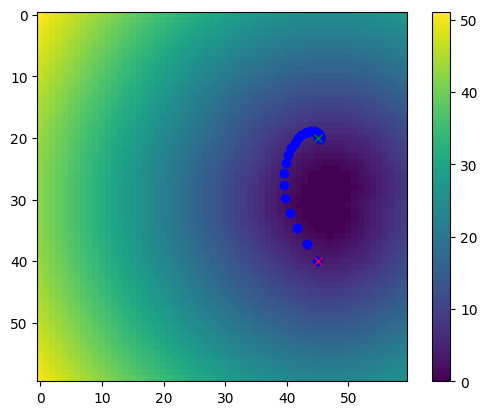

In [226]:

plt.imshow(sdf)
for x, y, a, b in trajectory.squeeze():
    plt.plot(x/CELL_SIZE, y/CELL_SIZE, 'bo')

plt.plot(CURRENT_STATE[0]/CELL_SIZE, CURRENT_STATE[1]/CELL_SIZE, 'rx')
plt.plot(GOAL_POSITION[0]/CELL_SIZE, GOAL_POSITION[1]/CELL_SIZE, 'gx')
plt.colorbar()
plt.show()
